In [9]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from ngboost import NGBRegressor
from ngboost.distns import Normal, Poisson
from ngboost.scores import CRPScore, MLE
from ngboost.ngboost import NGBoost
from sklearn.tree import DecisionTreeRegressor

from hyperopt import hp, tpe, space_eval
from hyperopt.pyll.base import scope
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK, Trials

import logging

In [2]:
# options
pd.set_option('max_columns',100)
plt.style.use('fivethirtyeight')
warnings.simplefilter('ignore')
seed = 1

In [3]:
# Data dirctory
data_dir = Path('../data/')
data_file = data_dir / 'data.csv'

In [4]:
# Data
# 0:AAR / 1:EAD / 2:ADR / 3:EDD는 고정  , 나머지는 순서 상관 없음
Data = pd.read_csv(data_file, index_col=0)

***
***
***

# Data Selection

In [5]:
# 필요없는 것을 버리기
Data_temp = Data.drop('TMP', axis=1)
Data_temp = Data_temp.drop('TD', axis=1)
Data_temp = Data_temp.drop('HM', axis=1)
Data_temp = Data_temp.drop('PS', axis=1)
Data_temp = Data_temp.drop('PA', axis=1)

#고층바람 너무 높은 고도는 뺴자 
Data_temp = Data_temp.drop('WD_400', axis=1)
Data_temp = Data_temp.drop('WD_500', axis=1)
Data_temp = Data_temp.drop('WD_700', axis=1)
Data_temp = Data_temp.drop('WS_400', axis=1)
Data_temp = Data_temp.drop('WS_500', axis=1)
Data_temp = Data_temp.drop('WS_700', axis=1)

# drop TAF
for i in range(6,30,6):
    Data_temp = Data_temp.drop(f'WDIR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WSPD_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WG_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'VIS_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WC_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_1LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_1LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_2LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_2LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_3LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_3LYR_t{i}', axis=1)

In [6]:
# 각 시간에 맞는 TAF로 나누기
taf6 = [12,18,24]
taf12 = [6,18,24]
taf18 = [6,12,24]
taf24 = [6,12,18]
    
# 각 시간에 맞는 taf 넣기
data_taf = {}
for i in range(6,30,6):
    data_taf[f'Data_{i}'] = Data_temp    
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WDIR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WSPD_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WG_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'VIS_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WC_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_1LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_1LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_2LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_2LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_3LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_3LYR_t{i}'])
    
Data_6 = data_taf['Data_6']
Data_12 = data_taf['Data_12']
Data_18 = data_taf['Data_18']
Data_24 = data_taf['Data_24']

In [34]:
# 예측할 시간에 맞는 Data로 넣기
# 0-6 : Data_6 / 6-12 : Data_12 / 12-18 : Data_18 / 18-24 : Data_24
Data_raw = Data_6
Data_m = Data_6
Data_m = Data_m.drop('AAR', axis=1)
Data_m = Data_m.drop('ADR', axis=1)


# Arrival
y_a = Data_raw.AAR.to_numpy()
X_a = Data_m.to_numpy()
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size = 0.1, random_state = seed)
#X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.11, random_state = 13) 


# Departure
y_d = Data_raw.ADR.to_numpy()
X_d = Data_m.to_numpy()
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size = 0.1, random_state = seed)
#X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.11, random_state = 13) 

# val은 hyperparameter 검증에 사용
# 0.11 x 0.9 = 0.099

print('Training Data shape : ', Data_m.shape)
Data_m.tail()

Training Data shape :  (26304, 46)


,EAD,EDD,year,month,day,hour,DayName,Arpt_cond,P_Airp,P_AAR,P_ADR,Arrival_remainder,Departure_remainder,WD_850,WD_925,WD_1000,WS_850,WS_925,WS_1000,WD,WSPD,WS_GST,VIS,WC,RN,CA_TOT,CLA_1LYR,BASE_1LYR,CLA_2LYR,BASE_2LYR,CLA_3LYR,BASE_3LYR,CLA_4LYR,BASE_4LYR,RVR,WDIR_t6,WSPD_t6,WG_t6,VIS_t6,WC_t6,CLA_1LYR_t6,BASE_1LYR_t6,CLA_2LYR_t6,BASE_2LYR_t6,CLA_3LYR_t6,BASE_3LYR_t6
26299,9.0,8.0,2020,12,31,19,4,1.0,1.0,5.0,13.0,9.0,0.0,270.0,280.0,325.0,39.0,29.0,16.0,32,6,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26300,6.0,6.0,2020,12,31,20,4,1.0,1.0,11.0,11.0,0.0,0.0,270.0,280.0,325.0,39.0,29.0,16.0,31,11,0.0,1000,1,0.0,1,1.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26301,3.0,8.0,2020,12,31,21,4,1.0,1.0,7.0,5.0,0.0,1.0,270.0,280.0,325.0,39.0,29.0,16.0,32,11,0.0,1000,1,0.0,2,2.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26302,4.0,13.0,2020,12,31,22,4,1.0,1.0,3.0,9.0,0.0,0.0,270.0,280.0,325.0,39.0,29.0,16.0,34,9,0.0,1000,1,0.0,1,1.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26303,1.0,15.0,2020,12,31,23,4,1.0,1.0,6.0,11.0,0.0,2.0,270.0,280.0,325.0,39.0,29.0,16.0,2,6,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0


***
***
***

# NGBoost

## Hypteropt

In [36]:
logging.basicConfig(
    # filename = "errors.log",
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger()

In [37]:
b1 = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 127,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)
b2 = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 255,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)
b3 = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 63,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)


space = {
    'learning_rate':hp.quniform('learning_rate', .0005, 0.01, 0.001),
    'minibatch_frac':hp.quniform('minibatch_frac', 0.5, 1.0, 0.1),
    'col_sample':hp.quniform('col_sample', 0.5, 1.0, 0.1),
    'Base':hp.choice('Base', [b1, b2, b3])
}

default_params = {"Dist" : Poisson,
                  "Score" : MLE,
                  "n_estimators":10000000,
                  "verbose_eval":100,
                  "random_state":13}

In [38]:
def objective_a(params):
    
    params.update(default_params)
    
    print(params)
    ngb_arrival = NGBRegressor(**params).fit(X_train_a, y_train_a,
                                             X_val = X_test_a, 
                                             Y_val = y_test_a, 
                                             early_stopping_rounds = 10)
    loss = ngb_arrival.evals_result['val']['LOGSCORE'][ngb_arrival.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

In [39]:
def objective_d(params):
    
    params.update(default_params)
    
    print(params)
    ngb_departure = NGBRegressor(**params).fit(X_train_d, y_train_d,
                                             X_val = X_test_d, 
                                             Y_val = y_test_d, 
                                             early_stopping_rounds = 10)
    loss = ngb_departure.evals_result['val']['LOGSCORE'][ngb_departure.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

In [ ]:
# Arrival 

TRIALS = Trials()
logger.info("Start parameter optimization...")


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective_a,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
logger.info("...done")

2021-07-30 09:43:52 INFO     Start parameter optimization...


  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

2021-07-30 09:43:52 INFO     build_posterior_wrapper took 0.001034 seconds
2021-07-30 09:43:52 INFO     TPE using 0 trials


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.003, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7165 val_loss=6.7114 scale=1.0000 norm=0.5892                                                          
[iter 100] loss=4.8510 val_loss=4.8314 scale=2.0000 norm=0.8873                                                        
[iter 200] loss=3.4006 val_loss=3.4222 scale=2.0000 norm=0.6228                                                        
[iter 300] loss=2.8314 val_loss=2.8671 scale=2.0000 norm=0.4850                                                        
[iter 400] loss=2.5953 val_loss=2.6353 scale=2.0000 norm=0.4069                                   

2021-07-30 09:46:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.003, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  1%|▍                                            | 1/100 [02:22<3:55:56, 142.99s/trial, best loss: 2.4678881485073005]

2021-07-30 09:46:15 INFO     build_posterior_wrapper took 0.003017 seconds
2021-07-30 09:46:15 INFO     TPE using 1/1 trials with best loss 2.467888


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.9, 'learning_rate': 0.005, 'minibatch_frac': 0.7000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7087 val_loss=6.6957 scale=1.0000 norm=0.5893                                                          
[iter 100] loss=3.6621 val_loss=3.6671 scale=2.0000 norm=0.6794                                                        
[iter 200] loss=2.6632 val_loss=2.7056 scale=2.0000 norm=0.4306                                                        
[iter 300] loss=2.4500 val_loss=2.5060 scale=2.0000 norm=0.3435                                                        
[iter 400] loss=2.4029 val_loss=2.4652 scale=2.0000 norm=0.3181                                   

2021-07-30 09:47:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,
                      min_samples_split=3, random_state=1), 'col_sample': 0.9, 'learning_rate': 0.005, 'minibatch_frac': 0.7000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  2%|▉                                            | 2/100 [03:49<2:59:01, 109.60s/trial, best loss: 2.4544150570363765]

2021-07-30 09:47:42 INFO     build_posterior_wrapper took 0.002000 seconds
2021-07-30 09:47:42 INFO     TPE using 2/2 trials with best loss 2.454415


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.001, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7165 val_loss=6.7250 scale=1.0000 norm=0.5892                                                          
[iter 100] loss=6.0681 val_loss=6.0568 scale=1.0000 norm=0.5392                                                        
[iter 200] loss=5.4854 val_loss=5.5006 scale=1.0000 norm=0.4939                                                        
[iter 300] loss=4.7853 val_loss=4.8004 scale=2.0000 norm=0.8778                                                        
[iter 400] loss=4.1275 val_loss=4.1581 scale=2.0000 norm=0.7662                                   

2021-07-30 09:54:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.001, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  3%|█▎                                           | 3/100 [10:22<6:26:14, 238.91s/trial, best loss: 2.4515918942758494]

2021-07-30 09:54:14 INFO     build_posterior_wrapper took 0.002991 seconds
2021-07-30 09:54:14 INFO     TPE using 3/3 trials with best loss 2.451592


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.001, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7218 val_loss=6.7251 scale=1.0000 norm=0.5895                                                          
[iter 100] loss=6.0712 val_loss=6.0627 scale=1.0000 norm=0.5391                                                        
[iter 200] loss=5.5050 val_loss=5.5068 scale=1.0000 norm=0.4955                                                        
[iter 300] loss=4.7921 val_loss=4.8016 scale=2.0000 norm=0.8774                                                        
[iter 400] loss=4.1556 val_loss=4.1666 scale=2.0000 norm=0.7697                                   

2021-07-30 10:02:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.001, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  4%|█▊                                           | 4/100 [18:26<8:57:17, 335.81s/trial, best loss: 2.4515918942758494]

2021-07-30 10:02:19 INFO     build_posterior_wrapper took 0.001998 seconds
2021-07-30 10:02:19 INFO     TPE using 4/4 trials with best loss 2.451592


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.007, 'minibatch_frac': 0.7000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7087 val_loss=6.6812 scale=1.0000 norm=0.5893                                                          
[iter 100] loss=3.0772 val_loss=3.1171 scale=2.0000 norm=0.5503                                                        
[iter 200] loss=2.4467 val_loss=2.5268 scale=2.0000 norm=0.3388                                                        
[iter 300] loss=2.3606 val_loss=2.4596 scale=2.0000 norm=0.2926                                                        
[iter 400] loss=2.3425 val_loss=2.4513 scale=2.0000 norm=0.2780                    

2021-07-30 10:03:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.007, 'minibatch_frac': 0.7000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  5%|██▎                                          | 5/100 [19:24<6:13:05, 235.64s/trial, best loss: 2.4511423638584877]

2021-07-30 10:03:17 INFO     build_posterior_wrapper took 0.000997 seconds
2021-07-30 10:03:17 INFO     TPE using 5/5 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.007, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7218 val_loss=6.6828 scale=1.0000 norm=0.5895                                                          
[iter 100] loss=3.1200 val_loss=3.1484 scale=2.0000 norm=0.5602                                                        
[iter 200] loss=2.4930 val_loss=2.5519 scale=2.0000 norm=0.3630                                                        
[iter 300] loss=2.4050 val_loss=2.4756 scale=1.0000 norm=0.1609                                                        
[iter 400] loss=2.3868 val_loss=2.4641 scale=2.0000 norm=0.3149                                   

2021-07-30 10:04:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.007, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  6%|██▋                                          | 6/100 [20:27<4:37:22, 177.04s/trial, best loss: 2.4511423638584877]

2021-07-30 10:04:20 INFO     build_posterior_wrapper took 0.002033 seconds
2021-07-30 10:04:20 INFO     TPE using 6/6 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 0.5, 'learning_rate': 0.004, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7165 val_loss=6.7046 scale=1.0000 norm=0.5892                                                          
[iter 100] loss=4.2166 val_loss=4.2091 scale=2.0000 norm=0.7809                                                        
[iter 200] loss=3.0084 val_loss=3.0406 scale=2.0000 norm=0.5318                                                        
[iter 300] loss=2.6283 val_loss=2.6727 scale=2.0000 norm=0.4209                                                        
[iter 400] loss=2.4985 val_loss=2.5441 scale=2.0000 norm=0.3683                                                  

2021-07-30 10:06:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 0.5, 'learning_rate': 0.004, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  7%|███▏                                         | 7/100 [22:12<3:57:48, 153.42s/trial, best loss: 2.4511423638584877]

2021-07-30 10:06:05 INFO     build_posterior_wrapper took 0.002012 seconds
2021-07-30 10:06:05 INFO     TPE using 7/7 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7218 val_loss=6.6664 scale=1.0000 norm=0.5895                                                          
[iter 100] loss=2.7443 val_loss=2.8006 scale=2.0000 norm=0.4576                                                        
[iter 200] loss=2.3810 val_loss=2.4721 scale=2.0000 norm=0.3024                                                        
[iter 300] loss=2.3454 val_loss=2.4530 scale=1.0000 norm=0.1408                                                        
== Early stopping achieved.                                                        

2021-07-30 10:07:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  8%|███▌                                         | 8/100 [23:07<3:07:05, 122.01s/trial, best loss: 2.4511423638584877]

2021-07-30 10:07:00 INFO     build_posterior_wrapper took 0.000995 seconds
2021-07-30 10:07:00 INFO     TPE using 8/8 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 1.0, 'learning_rate': 0.006, 'minibatch_frac': 0.7000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7087 val_loss=6.6878 scale=1.0000 norm=0.5893                                                          
[iter 100] loss=3.3439 val_loss=3.3452 scale=2.0000 norm=0.6157                                                        
[iter 200] loss=2.5679 val_loss=2.5991 scale=2.0000 norm=0.3943                                                        
[iter 300] loss=2.4479 val_loss=2.4860 scale=2.0000 norm=0.3462                                                        
[iter 400] loss=2.4294 val_loss=2.4688 scale=1.0000 norm=0.1676                                   

2021-07-30 10:08:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 1.0, 'learning_rate': 0.006, 'minibatch_frac': 0.7000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


  9%|████                                         | 9/100 [24:35<2:49:07, 111.52s/trial, best loss: 2.4511423638584877]

2021-07-30 10:08:28 INFO     build_posterior_wrapper took 0.001997 seconds
2021-07-30 10:08:28 INFO     TPE using 9/9 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 0.8, 'learning_rate': 0.003, 'minibatch_frac': 0.6000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.6922 val_loss=6.7107 scale=1.0000 norm=0.5882                                                          
[iter 100] loss=4.8202 val_loss=4.7932 scale=2.0000 norm=0.8818                                                        
[iter 200] loss=3.3526 val_loss=3.3720 scale=2.0000 norm=0.6129                                                        
[iter 300] loss=2.7982 val_loss=2.8298 scale=2.0000 norm=0.4769                                                        
[iter 400] loss=2.5731 val_loss=2.6106 scale=2.0000 norm=0.4004                                   

2021-07-30 10:10:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 0.8, 'learning_rate': 0.003, 'minibatch_frac': 0.6000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 10%|████▍                                       | 10/100 [26:33<2:50:08, 113.43s/trial, best loss: 2.4511423638584877]

2021-07-30 10:10:26 INFO     build_posterior_wrapper took 0.002004 seconds
2021-07-30 10:10:26 INFO     TPE using 10/10 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 0.9, 'learning_rate': 0.005, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7165 val_loss=6.6961 scale=1.0000 norm=0.5892                                                          
[iter 100] loss=3.6948 val_loss=3.6891 scale=2.0000 norm=0.6855                                                        
[iter 200] loss=2.6914 val_loss=2.7214 scale=2.0000 norm=0.4408                                                        
[iter 300] loss=2.4790 val_loss=2.5186 scale=2.0000 norm=0.3585                                                        
[iter 400] loss=2.4340 val_loss=2.4759 scale=2.0000 norm=0.3386                                                  

2021-07-30 10:12:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 0.9, 'learning_rate': 0.005, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 11%|████▊                                       | 11/100 [28:17<2:44:11, 110.69s/trial, best loss: 2.4511423638584877]

2021-07-30 10:12:10 INFO     build_posterior_wrapper took 0.000999 seconds
2021-07-30 10:12:10 INFO     TPE using 11/11 trials with best loss 2.451142


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.8, 'learning_rate': 0.001, 'minibatch_frac': 0.6000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.6922 val_loss=6.7250 scale=1.0000 norm=0.5882                                                          
[iter 100] loss=6.0707 val_loss=6.0540 scale=1.0000 norm=0.5387                                                        
[iter 200] loss=5.4868 val_loss=5.4965 scale=1.0000 norm=0.4945                                                        
[iter 300] loss=4.8107 val_loss=4.8114 scale=2.0000 norm=0.8829                                                        
[iter 400] loss=4.1539 val_loss=4.1624 scale=2.0000 norm=0.7714                                   

2021-07-30 10:18:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.8, 'learning_rate': 0.001, 'minibatch_frac': 0.6000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 12%|█████▎                                      | 12/100 [34:50<4:48:15, 196.54s/trial, best loss: 2.4502692663136036]

2021-07-30 10:18:43 INFO     build_posterior_wrapper took 0.002002 seconds
2021-07-30 10:18:43 INFO     TPE using 12/12 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.5, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.6714 val_loss=6.6691 scale=1.0000 norm=0.5876                                                          
[iter 100] loss=2.8015 val_loss=2.8377 scale=2.0000 norm=0.4797                                                        
[iter 200] loss=2.4285 val_loss=2.4939 scale=2.0000 norm=0.3286                                                        
[iter 300] loss=2.3892 val_loss=2.4654 scale=1.0000 norm=0.1585                                                        
[iter 400] loss=2.3738 val_loss=2.4625 scale=2.0000 norm=0.3118                    

2021-07-30 10:19:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.5, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 13%|█████▋                                      | 13/100 [35:25<3:34:04, 147.64s/trial, best loss: 2.4502692663136036]

2021-07-30 10:19:18 INFO     build_posterior_wrapper took 0.001992 seconds
2021-07-30 10:19:18 INFO     TPE using 13/13 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.5, 'learning_rate': 0.002, 'minibatch_frac': 0.5, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.6714 val_loss=6.7181 scale=1.0000 norm=0.5876                                                          
[iter 100] loss=5.5205 val_loss=5.4998 scale=1.0000 norm=0.4971                                                        
[iter 200] loss=4.1737 val_loss=4.2239 scale=2.0000 norm=0.7730                                                        
[iter 300] loss=3.3902 val_loss=3.4492 scale=2.0000 norm=0.6235                                                        
[iter 400] loss=2.9453 val_loss=3.0125 scale=2.0000 norm=0.5183                                                  

2021-07-30 10:21:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.5, 'learning_rate': 0.002, 'minibatch_frac': 0.5, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 14%|██████▏                                     | 14/100 [37:39<3:25:26, 143.33s/trial, best loss: 2.4502692663136036]

2021-07-30 10:21:32 INFO     build_posterior_wrapper took 0.003002 seconds
2021-07-30 10:21:32 INFO     TPE using 14/14 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.004, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7218 val_loss=6.7035 scale=1.0000 norm=0.5895                                                          
[iter 100] loss=4.1574 val_loss=4.1505 scale=2.0000 norm=0.7699                                                        
[iter 200] loss=2.9311 val_loss=2.9598 scale=2.0000 norm=0.5125                                                        
[iter 300] loss=2.5775 val_loss=2.6182 scale=2.0000 norm=0.3999                                                        
[iter 400] loss=2.4690 val_loss=2.5121 scale=2.0000 norm=0.3545                                   

2021-07-30 10:23:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.004, 'minibatch_frac': 0.9, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 15%|██████▌                                     | 15/100 [39:45<3:15:45, 138.18s/trial, best loss: 2.4502692663136036]

2021-07-30 10:23:38 INFO     build_posterior_wrapper took 0.000998 seconds
2021-07-30 10:23:38 INFO     TPE using 15/15 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.008, 'minibatch_frac': 0.6000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.6922 val_loss=6.6744 scale=1.0000 norm=0.5882                                                          
[iter 100] loss=2.9126 val_loss=2.9389 scale=2.0000 norm=0.5081                                                        
[iter 200] loss=2.4428 val_loss=2.5009 scale=2.0000 norm=0.3371                                                        
[iter 300] loss=2.3901 val_loss=2.4612 scale=2.0000 norm=0.3178                                                        
== Early stopping achieved.                                                        

2021-07-30 10:24:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=127,
                      min_samples_split=3, random_state=1), 'col_sample': 0.7000000000000001, 'learning_rate': 0.008, 'minibatch_frac': 0.6000000000000001, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 16%|███████                                     | 16/100 [40:25<2:32:12, 108.72s/trial, best loss: 2.4502692663136036]

2021-07-30 10:24:18 INFO     build_posterior_wrapper took 0.002002 seconds
2021-07-30 10:24:18 INFO     TPE using 16/16 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.004, 'minibatch_frac': 1.0, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7289 val_loss=6.7033 scale=1.0000 norm=0.5897                                                          
[iter 100] loss=4.1532 val_loss=4.1787 scale=2.0000 norm=0.7696                                                        
[iter 200] loss=2.9052 val_loss=2.9704 scale=2.0000 norm=0.5050                                                        
[iter 300] loss=2.5345 val_loss=2.6155 scale=2.0000 norm=0.3808                                                        
[iter 400] loss=2.4146 val_loss=2.5057 scale=2.0000 norm=0.3226                                   

2021-07-30 10:26:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.6000000000000001, 'learning_rate': 0.004, 'minibatch_frac': 1.0, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 17%|███████▍                                    | 17/100 [42:16<2:31:03, 109.19s/trial, best loss: 2.4502692663136036]

2021-07-30 10:26:08 INFO     build_posterior_wrapper took 0.002035 seconds
2021-07-30 10:26:08 INFO     TPE using 17/17 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,                                            
                      min_samples_split=3, random_state=1), 'col_sample': 1.0, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7165 val_loss=6.6658 scale=1.0000 norm=0.5892                                                          
[iter 100] loss=2.7864 val_loss=2.8080 scale=2.0000 norm=0.4739                                                        
[iter 200] loss=2.4469 val_loss=2.4867 scale=2.0000 norm=0.3450                                                        
[iter 300] loss=2.4215 val_loss=2.4670 scale=1.0000 norm=0.1698                                                        
== Early stopping achieved.                                                                       

2021-07-30 10:27:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=63,
                      min_samples_split=3, random_state=1), 'col_sample': 1.0, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 18%|████████                                     | 18/100 [43:12<2:07:27, 93.27s/trial, best loss: 2.4502692663136036]

2021-07-30 10:27:05 INFO     build_posterior_wrapper took 0.001037 seconds
2021-07-30 10:27:05 INFO     TPE using 18/18 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.8, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.5, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.6714 val_loss=6.6669 scale=1.0000 norm=0.5876                                                          
[iter 100] loss=2.7503 val_loss=2.8011 scale=2.0000 norm=0.4645                                                        
[iter 200] loss=2.3807 val_loss=2.4721 scale=2.0000 norm=0.2971                                                        
[iter 300] loss=2.3407 val_loss=2.4531 scale=2.0000 norm=0.2783                                                        
== Early stopping achieved.                                                                       

2021-07-30 10:27:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,
                      min_samples_split=3, random_state=1), 'col_sample': 0.8, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.5, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}


 19%|████████▌                                    | 19/100 [43:48<1:42:34, 75.99s/trial, best loss: 2.4502692663136036]

2021-07-30 10:27:40 INFO     build_posterior_wrapper took 0.002001 seconds
2021-07-30 10:27:40 INFO     TPE using 19/19 trials with best loss 2.450269


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=255,                                           
                      min_samples_split=3, random_state=1), 'col_sample': 0.9, 'learning_rate': 0.009000000000000001, 'minibatch_frac': 0.8, 'Dist': <class 'ngboost.distns.poisson.Poisson'>, 'Score': <class 'ngboost.scores.LogScore'>, 'n_estimators': 10000000, 'verbose_eval': 100, 'random_state': 13}
[iter 0] loss=6.7165 val_loss=6.6663 scale=1.0000 norm=0.5892                                                          
 19%|████████▌                                    | 19/100 [43:48<1:42:34, 75.99s/trial, best loss: 2.4502692663136036]

In [ ]:
best_params = space_eval(space, best)
best_params

In [ ]:
# Departure 

TRIALS = Trials()
logger.info("Start parameter optimization...")


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective_a,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
logger.info("...done")

In [ ]:
best_params = space_eval(space, best)
best_params

## NGBoost

In [10]:
# Arrival

tree_learner = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 127,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)

####################################################  Poisson -> NOrmal ######################################
ngb_arrival = NGBRegressor(Dist = Poisson,               # A distribution from ngboost.distns : Normal, LogNormal, Exponential...
                           Score = MLE,            # rule to compare probabilistic predictions P̂ to the observed data y, from ngboost.scores : LogScore, CRPScore...
                           Base = tree_learner,         # base learner to use in the boosting algorithm
                           natural_gradient = True,     # logical flag indicating whether the natural gradient should be used
                           verbose = True,
                           n_estimators = 10000000, 
                           learning_rate = 0.001,
                           minibatch_frac = 0.8,        # the percent subsample of rows to use in each boosting iteration
                           col_sample = 0.8,            
                           tol = 1e-5,                  # numerical tolerance to be used in optimization
                           random_state = 13)

ngb_arrival.fit(X_train_a, y_train_a,
                X_val = X_val_a,
                Y_val = y_val_a,
                sample_weight = None,                   # Weights of training data
                val_sample_weight = None,               # Weights of eval data
                train_loss_monitor = None,              # custom score or set of scores to track on the training set during training
                val_loss_monitor = None,                # custom score or set of scores to track on the validation set during training
                early_stopping_rounds = 2)

[iter 0] loss=6.7214 val_loss=6.6999 scale=1.0000 norm=0.5887
[iter 100] loss=6.0261 val_loss=6.0370 scale=1.0000 norm=0.5356
[iter 200] loss=5.4899 val_loss=5.4825 scale=1.0000 norm=0.4945
[iter 300] loss=4.8122 val_loss=4.7953 scale=2.0000 norm=0.8819
[iter 400] loss=4.1541 val_loss=4.1550 scale=2.0000 norm=0.7719
[iter 500] loss=3.6778 val_loss=3.6929 scale=2.0000 norm=0.6812
[iter 600] loss=3.3415 val_loss=3.3565 scale=2.0000 norm=0.6136
[iter 700] loss=3.0975 val_loss=3.1126 scale=2.0000 norm=0.5583
[iter 800] loss=2.9043 val_loss=2.9329 scale=2.0000 norm=0.5065
[iter 900] loss=2.7716 val_loss=2.8013 scale=2.0000 norm=0.4674
[iter 1000] loss=2.6719 val_loss=2.7048 scale=2.0000 norm=0.4324
[iter 1100] loss=2.5962 val_loss=2.6341 scale=2.0000 norm=0.4057
[iter 1200] loss=2.5419 val_loss=2.5824 scale=2.0000 norm=0.3861
[iter 1300] loss=2.5032 val_loss=2.5449 scale=2.0000 norm=0.3647
[iter 1400] loss=2.4749 val_loss=2.5176 scale=2.0000 norm=0.3525
[iter 1500] loss=2.4505 val_loss=2.49

NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse',
                                        max_leaf_nodes=127, min_samples_split=3,
                                        random_state=1),
             Dist=<class 'ngboost.distns.poisson.Poisson'>, col_sample=0.8,
             learning_rate=0.001, minibatch_frac=0.8, n_estimators=10000000,
             random_state=RandomState(MT19937) at 0x1E0B159AA40, tol=1e-05)

In [ ]:
# Departure

tree_learner = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 127,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)


ngb_departure = NGBRegressor(Dist = Normal,               # A distribution from ngboost.distns : Normal, LogNormal, Exponential...
                             Score = MLE,            # rule to compare probabilistic predictions P̂ to the observed data y, from ngboost.scores : LogScore, CRPScore...
                             Base = tree_learner,         # base learner to use in the boosting algorithm
                             natural_gradient = True,     # logical flag indicating whether the natural gradient should be used
                             verbose = True,
                             n_estimators = 10000000, 
                             learning_rate = 0.001,
                             minibatch_frac = 0.8,        # the percent subsample of rows to use in each boosting iteration
                             col_sample = 0.8,            
                             tol = 1e-5,                  # numerical tolerance to be used in optimization
                             random_state = 13)


ngb_departure.fit(X_train_d, y_train_d,
                X_val = X_val_d,
                Y_val = y_val_d,
                sample_weight = None,                   # Weights of training data
                val_sample_weight = None,               # Weights of eval data
                train_loss_monitor = None,              # custom score or set of scores to track on the training set during training
                val_loss_monitor = None,                # custom score or set of scores to track on the validation set during training
                early_stopping_rounds = 10)

In [11]:
# Arrival

print("Train set RMSE : " , np.sqrt(mean_squared_error(y_train_a, ngb_arrival.pred_dist(X_train_a).loc)))
print("Test set RMSE : " , np.sqrt(mean_squared_error(y_test_a, ngb_arrival.pred_dist(X_test_a).loc)))

print("Train set R^2 : " , r2_score(y_train_a, ngb_arrival.pred_dist(X_train_a).loc))
print("Test set R^2 : " , r2_score(y_test_a, ngb_arrival.pred_dist(X_test_a).loc))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Departure

print("Train set RMSE : " , np.sqrt(mean_squared_error(y_train_d, ngb_departure.pred_dist(X_train_d).loc)))
print("Test set RMSE : " , np.sqrt(mean_squared_error(y_test_d, ngb_departure.pred_dist(X_test_d).loc)))

print("Train set R^2 : " , r2_score(y_train_d, ngb_departure.pred_dist(X_train_d).loc))
print("Test set R^2 : " , r2_score(y_test_d, ngb_departure.pred_dist(X_test_d).loc))

In [ ]:
y_a_pred = ngb_arrival.pred_dist(X_a)
predictions = pd.DataFrame(y_a_pred.loc, columns=['Predictions'])
predictions_sd = pd.DataFrame(y_a_pred.scale, columns=['Standard Deviation'])
predictions_upper = pd.DataFrame(y_a_pred.dist.interval(0.95)[1], columns=['95% Predictions_upper'])    # 95% prediction interval
predictions_lower = pd.DataFrame(y_a_pred.dist.interval(0.95)[0], columns=['95% Predictions_lower'])
Actual_AAR = pd.DataFrame({'Actual AAR':y_a})
Date = pd.date_range(start='1/1/2019', end='12/31/2019 23:00', freq = '1H')

prediction =  pd.concat([pd.DataFrame({'Date':Date}), Actual_AAR, predictions, predictions_sd, 
                         predictions_upper, predictions_lower], axis = 1)

In [26]:
def plot_result(prediction, start=0, end=10):   

    fig, ax = plt.subplots(figsize=(22, 10))
    plt.fill_between(prediction['Date'][start:end], prediction['95% Predictions_lower'][start:end],  prediction['95% Predictions_upper'][start:end], 
                     label = '95% Prediction Interval', color='gray', alpha=0.5)
    plt.plot(prediction['Date'][start:end], prediction['Predictions'][start:end], label = 'Predictions', lw=2)
    plt.scatter(prediction['Date'][start:end], prediction['Predictions'][start:end], lw=3)
    plt.scatter(prediction['Date'][start:end], prediction['Actual AAR'][start:end], label = 'Actual AAR', color='r', lw=3)

    ax.legend(fontsize = 15)
    #plt.title('Hourly Power Consumption Actual vs. Predicted Values with Prediction Intervals')
    plt.xlabel('Time')
    plt.ylabel('Arrivals per hour')
    plt.show()

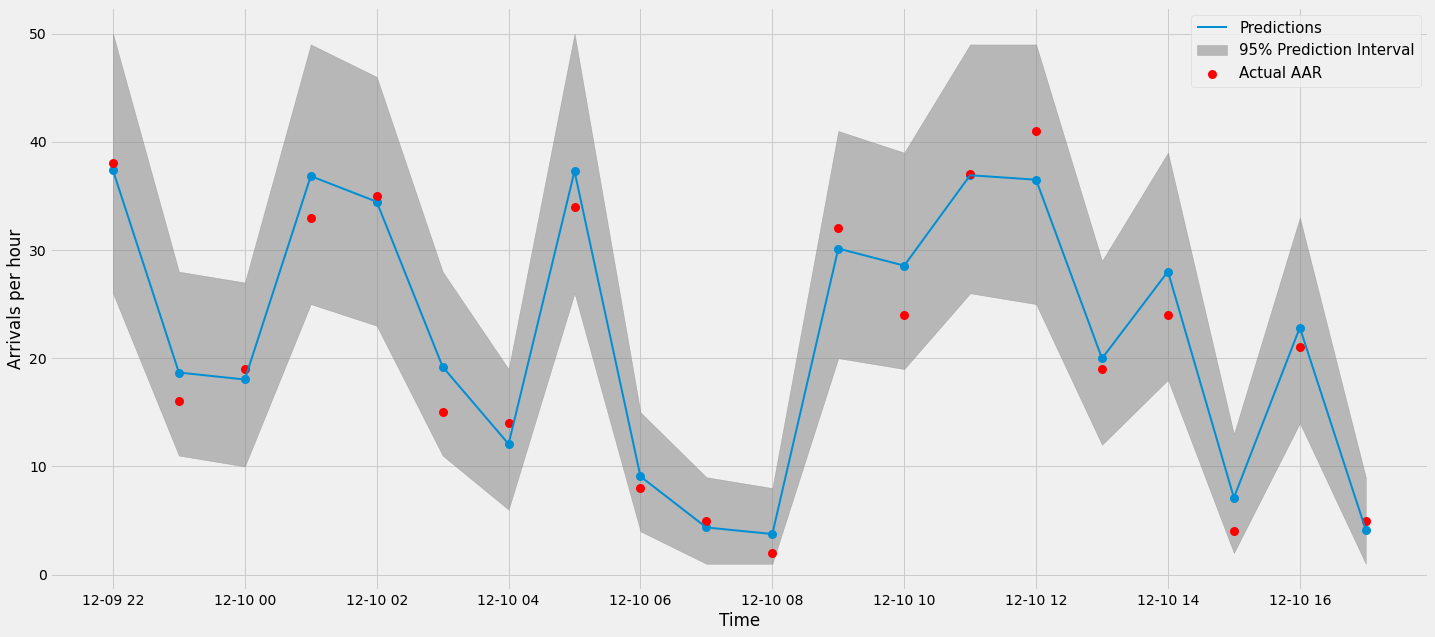

In [28]:
plot_result(prediction, start = 8230, end = 8250)

# NGBoost - example

## NGBoost

In [ ]:
X, Y = load_boston(True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
# prediction
Y_preds = ngb.predict(X_test)

In [ ]:
# estimated distributional parameters at a set of point
Y_dists = ngb.pred_dist(X_test)

Y_dists[0:5].params    

# loc : mean
# scale : standard deviation

In [ ]:
# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

## Survival Regression

In [ ]:
import numpy as np
from ngboost import NGBSurvival
from ngboost.distns import LogNormal

# Distribution Estimator